In [70]:
# Importando o framework para predição das imagens
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [71]:
# Importando bibliotecas para analises de imagens
import cv2
import imgaug as im
from PIL import Image
from moviepy.video.io.bindings import mplfig_to_npimage

# Importando bibliotecas do sistema
import os
import base64

# Importa biblioteca para rede neural
import keras
import segmentation_models as sm
from sklearn import metrics

# Importa bibliotecas para analise de dados
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re

# Importa bibliotecas para visualização de dataframes com imagens
import pdfkit as pdf
from io import BytesIO
from IPython.display import HTML


In [72]:
path_name_image = 'D:/Sensix/Python/img_generated/img_original/sugarcane/rgb/'
path_name_image_md = 'D:/Sensix/Python/img_generated/img_original/sugarcane/ground-truth/'
path_model_0 = 'D:/Sensix/Python/Redes Neurais/diverses_backbones/segment_weed_2.h5'
path_model_1 = 'D:/Sensix/Python/Redes Neurais/marcacoes_externas/vgg16_Linknet_2.hdf5'
path_model_2 = 'D:/Sensix/Python/Redes Neurais/marcacoes_filtro_verde/vgg16_Linknet_Test13.hdf5'


In [73]:
def plot_metrics(path_name_image, path_name_image_md, path_model_0, path_model_1, path_model_2):
    model_0 = sm.Linknet('vgg16', encoder_weights='imagenet')
    model_1 = sm.Linknet('vgg16', encoder_weights='imagenet')
    model_2 = sm.Linknet('vgg16', encoder_weights='imagenet')

    model_0.load_weights(path_model_0)
    model_1.load_weights(path_model_1)
    model_2.load_weights(path_model_2)

    original_img = []
    binary_marked = []

    real = []
    real_marked = []
    real_model_0 = []
    real_model_1 = []
    real_model_2 = []

    name_model = ['model_0','model_1', 'model_2']

    for name_image, j in zip(os.listdir(path_name_image), range(30)):
        image_rgb = cv2.imread(path_name_image + name_image)
        image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB) / 255
        original_img.append(image_rgb)

        img = np.array(image_rgb)
        img = img * 255
        img = img.astype(np.uint8)
        real.append(img)
            
        for i in range(3): 
            image = image_rgb.copy()
            pred = eval(str(name_model[i]) + '.predict(np.array([image]))[0]')
            pred = np.array(pred)
            pred = pred[:,:,0]

            pred[pred > 0.1] = 1
            pred[pred < 0.1] = 0
            
            eval('binary_model_' + str(i) + '.append(pred)')

            image = image * 255
            image[pred == 1] = [255,0,0]
            image = image.astype(np.uint8)

            eval('real_model_' + str(i) + '.append(image)')
            
            del pred, image

        
    for name_image_md, i in zip(os.listdir(path_name_image_md), range(len(original_img))):
        image_rgb = cv2.imread(path_name_image_md + name_image_md)
        
        image = image_rgb.copy()
        image = np.array(image)
        image = image[:,:,0]

        image[image < 1 ] = 0
        image[image >= 1] = 1
        real_img = original_img[i]

        binary_marked.append(image)

        real_img = real_img * 255   
        real_img[image == 1] = [255,0,0]
        real_img = real_img.astype(np.uint8)
        
        real_marked.append(real_img)

        del real_img, image

    def get_thumbnail(path):
        i = Image.fromarray(path)
        i.thumbnail((150, 150), Image.LANCZOS)
        return i

    def image_base64(im):
        if isinstance(im, str):
            im = get_thumbnail(im)
        with BytesIO() as buffer:
            im.save(buffer, 'jpeg')
            return base64.b64encode(buffer.getvalue()).decode()

    def image_formatter(im):
        return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

    dict_predict_images = {'path_imgs': real, 'path_marked': real_marked, 'path_model_0': real_model_0, 'path_model_1': real_model_1, 'path_model_2': real_model_2}

    df = pd.DataFrame(dict_predict_images)

    df['imgs'] = df.path_imgs.map(lambda f: get_thumbnail(f))
    df['imgs_marked'] = df.path_marked.map(lambda f: get_thumbnail(f))
    df['model_0'] = df.path_model_0.map(lambda f: get_thumbnail(f))
    df['model_1'] = df.path_model_1.map(lambda f: get_thumbnail(f))
    df['model_2'] = df.path_model_2.map(lambda f: get_thumbnail(f))

    table = HTML(df[['imgs', 'imgs_marked',
                 'model_0', 
                 'model_1', 
                 'model_2']].to_html(#'table.html', 
                                         formatters={'imgs': image_formatter,
                                         'imgs_marked': image_formatter,
                                         'model_0': image_formatter,
                                         'model_1': image_formatter,
                                         'model_2': image_formatter},
                                         escape=False))

    #pdf.from_file('table.html', 'table.pdf')

    dict_metrics = {'metrics_model_0': {'vl_jac': [], 'vl_dic': [], 'vl_pre': [], 'vl_acc': []},
                'metrics_model_1': {'vl_jac': [], 'vl_dic': [], 'vl_pre': [], 'vl_acc': []},
                'metrics_model_2': {'vl_jac': [], 'vl_dic': [], 'vl_pre': [], 'vl_acc': []}}

    for i in range(3):
        for j in range(len(binary_marked)):
            vl_jac = round(metrics.jaccard_score(eval('binary_model_' + str(i) + '[j]'), binary_marked[j], average='micro'), 2)
            vl_dic = round(metrics.f1_score(binary_marked[j], eval('binary_model_' + str(i) + '[j]'), average='micro'), 2)
            vl_pre = round(metrics.precision_score(binary_marked[j], eval('binary_model_' + str(i) + '[j]'), average='micro'), 2)
            vl_acc = round(metrics.accuracy_score(binary_marked[j], eval('binary_model_' + str(i) + '[j]')), 2)
            
            x = str(('metrics_model_' + str(i)))

            dict_metrics[x]['vl_jac'].append(vl_jac)
            dict_metrics[x]['vl_dic'].append(vl_dic)
            dict_metrics[x]['vl_pre'].append(vl_pre)
            dict_metrics[x]['vl_acc'].append(vl_acc)

            del vl_jac, vl_dic, vl_pre, vl_acc

    dict_of_df = {k: pd.DataFrame(v) for k,v in dict_metrics.items()}
    df_metrics = pd.concat(dict_of_df, axis=1)
    name_metrics = ['vl_jac', 'vl_dic', 'vl_pre', 'vl_acc']

    for name in name_metrics:
        mm_0 = df_metrics['metrics_model_0'][str(name)]
        mm_1 = df_metrics['metrics_model_1'][str(name)]
        mm_2 = df_metrics['metrics_model_2'][str(name)]

        indx = df_metrics.index

        fig, ax = plt.subplots()
        ax.set_ylim(0, 1)
        ax.plot(indx, mm_0, 'g', label = 'Model_0')
        ax.plot(indx, mm_1, 'r', label = 'Model_1')
        ax.plot(indx, mm_2, 'y', label = 'Model_2')
        plt.ylabel(str(name))
        plt.xlabel('Image')
        r = re.sub("vl_","", str(name))
        plt.title('Métrica de ' + str(r))
        ax.legend(loc='best')

        buf = BytesIO()
        fig.savefig(buf, format="png", dpi=180)
        buf.seek(0)
        img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        buf.close()
        img = cv2.imdecode(img_arr, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        eval('plot_' + str(r) + '=' + str(img))

        del mm_0, mm_1, mm_2, img

        return plot_jac, plot_dic, plot_pre, plot_acc


C:\Users\flavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\flavy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SyntaxError: invalid syntax (<string>, line 1)

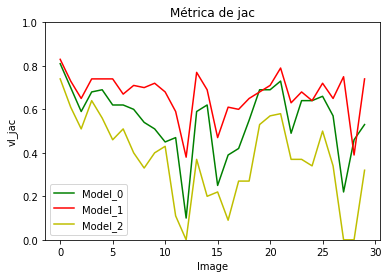

In [74]:
plot_metrics(path_name_image, path_name_image_md, path_model_0, path_model_1, path_model_2)